### ref : www.kaggle.com/sandeepbhogaraju/text-summarization-with-seq2seq-model
### ref : https://wikidocs.net/72820
### ref : https://lovit.github.io/nlp/2019/04/30/textrank/
### ref : https://frhyme.github.io/python-lib/nlp_spacy_1/

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import re
import spacy

import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# Function for checking dataframe
def show_table(df, sample_num=2):
    print('>>> shape :', df.shape)
    print('>>> number of NA :', df.isna().sum().sum())
    
    if df.shape[0] <= sample_num*2:
        display(df)
    else:
        display(pd.concat([df.head(sample_num), df.tail(sample_num)]))

/kaggle/input/news-summary/news_summary_more.csv
/kaggle/input/news-summary/news_summary.csv


## Prepare Data

In [2]:
raw_df = pd.read_csv('../input/news-summary/news_summary_more.csv', encoding='iso-8859-1')
show_table(raw_df)

>>> shape : (98401, 2)
>>> number of NA : 0


,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
98399,Snoop Dogg aims gun at clown dressed as Trump ...,A new music video shows rapper Snoop Dogg aimi...
98400,Madhesi Morcha withdraws support to Nepalese g...,"Madhesi Morcha, an alliance of seven political..."


In [3]:
summary_df = pd.read_csv('../input/news-summary/news_summary.csv', encoding='iso-8859-1')
summary_df['text_concat'] = summary_df['author'].str.cat(summary_df['date'], sep=' ').str.cat(summary_df['read_more'], sep=' ').str.cat(summary_df['text'], sep=' ').str.cat(summary_df['ctext'], sep=' ')
show_table(summary_df)

>>> shape : (4514, 7)
>>> number of NA : 236


,author,date,headlines,read_more,text,ctext,text_concat
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...,"Chhavi Tyagi 03 Aug 2017,Thursday http://www.h..."
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo...","Daisy Mowke 03 Aug 2017,Thursday http://www.hi..."
4512,Pragya Swastik,"07 Dec 2016,Wednesday","Asha Bhosle gets ?53,000 power bill for unused...",http://indiatoday.intoday.in/story/singer-asha...,The Maharashtra government has initiated an in...,Maharahstra Power Minister Chandrashekhar Bawa...,"Pragya Swastik 07 Dec 2016,Wednesday http://in..."
4513,Chhavi Tyagi,"03 Aug 2017,Thursday",More than half of India's languages may die in...,http://indiatoday.intoday.in/story/indian-lang...,At least 400 languages or more than half langu...,More than half of the languages spoken by Indi...,"Chhavi Tyagi 03 Aug 2017,Thursday http://india..."


In [4]:
pre_df = pd.DataFrame({
    'text':pd.concat([raw_df['text'], summary_df['text_concat']], ignore_index=True),
    'summary':pd.concat([raw_df['headlines'], summary_df['headlines']], ignore_index=True)
})
show_table(pre_df)

>>> shape : (102915, 2)
>>> number of NA : 118


,text,summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...
102913,"Pragya Swastik 07 Dec 2016,Wednesday http://in...","Asha Bhosle gets ?53,000 power bill for unused..."
102914,"Chhavi Tyagi 03 Aug 2017,Thursday http://india...",More than half of India's languages may die in...


## Perform Data Cleaning

In [5]:
# Function for removing non-alphabetic characters from string - order of regex is very important
def text_strip(input_str):
    # remove escape characters
    res_str = re.sub('(\\t)', ' ', str(input_str)).lower()
    res_str = re.sub('(\\r)', ' ', res_str)
    res_str = re.sub('(\\n)', ' ', res_str)
    
    # remove ( _ - ~ + . ) if it occurs more than one time consequently 
    res_str = re.sub('(__+)', ' ', res_str)
    res_str = re.sub('(--+)', ' ', res_str)
    res_str = re.sub('(\+\++)', ' ', res_str)
    res_str = re.sub('(\,\,+)', ' ', res_str)
    # res_str = re.sub('(~~+)', ' ', res_str)
    
    # remove certain characters
    res_str = re.sub(r'[<>()|&©ø\[\]\'\",;?~*!]', ' ', res_str)
    res_str = re.sub('(mailto:)', ' ', res_str)
    
    res_str = re.sub(r'(\\x9\d)', ' ', res_str)  # remove \x9#
    
    res_str = re.sub('([Ii][Nn][Cc]\d+)', 'INC_NUM', res_str)  # replace INC nums with INC_NUM
    res_str = re.sub('([Cc][Mm]\d+)|([Cc][Hh][Gg]\d+)', 'CM_NUM', res_str)  # replace CM# and CHG# with CM_NUM
    
    # remove ( . - : ) at end of words (not between)
    res_str = re.sub('(\.\s+)', ' ', res_str)
    res_str = re.sub('(\-\s+)', ' ', res_str)
    res_str = re.sub('(\:\s+)', ' ', res_str)
    
    res_str = re.sub('(\s+.\s)', ' ', res_str)  # remove any single characters hanging between 2 spaces
    
    # replace any url such as https://abc.xyz.net/browse/sdf-5327 ==> abc.xyz.net
    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', res_str)
        repl_url = url.group(3)
        res_str = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, res_str)
    except:
        pass  # there might be emails without url in them
    
    res_str = re.sub('(\s+)', ' ', res_str)  # remove multiple spaces
    res_str = re.sub('(\s+.\s+)', ' ', res_str)  # remove any single characters hanging between 2 spaces (Should always be last)
    
    return res_str

In [6]:
%%time

brief_cleaning1 = pre_df['text'].apply(text_strip)
brief_cleaning2 = pre_df['summary'].apply(text_strip)

show_table(pd.concat([pre_df['text'], brief_cleaning1], axis=1))

>>> shape : (102915, 2)
>>> number of NA : 118


,text,text
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",saurav kant an alumnus of upgrad and iiit-b pg...
1,Kunal Shah's credit card bill payment platform...,kunal shah credit card bill payment platform c...
102913,"Pragya Swastik 07 Dec 2016,Wednesday http://in...",pragya swastik 07 dec 2016 wednesday indiatoda...
102914,"Chhavi Tyagi 03 Aug 2017,Thursday http://india...",chhavi tyagi 03 aug 2017 thursday indiatoday.i...


CPU times: user 31 s, sys: 81.7 ms, total: 31.1 s
Wall time: 31.2 s


## Perform Data Cleaning - spaCy

In [7]:
nlp = spacy.load('en', disable=['ner', 'parser'])  # disable unneeded pipline components (ner, parser)
print(nlp)

In [8]:
%%time
# Taking advantage of spaCy .pipe() method to speed-up the cleaning process
# If data loss seems to be happening in this call, decrease the batch_size parameter

# Takes about 6-7 mins
pre_df['text_cleaned'] = pd.Series(nlp.pipe(brief_cleaning1, batch_size=5000, n_threads=-1)).astype(str)

CPU times: user 4min 56s, sys: 1min 38s, total: 6min 34s
Wall time: 6min 34s


In [9]:
%%time
# Taking advantage of spaCy .pipe() method to speed-up the cleaning process
# If data loss seems to be happening in this call, decrease the batch_size parameter

# Takes about 1-2 mins
pre_df['summary_cleaned'] = pd.Series(nlp.pipe(brief_cleaning2, batch_size=5000, n_threads=-1)).astype(str)
pre_df['summary_cleaned'] = pre_df['summary_cleaned'].apply(lambda sent : '_START_'+sent+'_END_')

CPU times: user 54.6 s, sys: 13 ms, total: 54.6 s
Wall time: 54.6 s


In [10]:
pre_df['text_cleaned_wordcnt'] = pre_df['text_cleaned'].apply(lambda sent : len(sent.split()))
pre_df['summary_cleaned_wordcnt'] = pre_df['summary_cleaned'].apply(lambda sent : len(sent.split()))

show_table(pre_df)

>>> shape : (102915, 6)
>>> number of NA : 118


,text,summary,text_cleaned,summary_cleaned,text_cleaned_wordcnt,summary_cleaned_wordcnt
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...,saurav kant an alumnus of upgrad and iiit-b pg...,_START_upgrad learner switches to career in ml...,56,12
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...,kunal shah credit card bill payment platform c...,_START_delhi techie wins free food from swiggy...,58,12
102913,"Pragya Swastik 07 Dec 2016,Wednesday http://in...","Asha Bhosle gets ?53,000 power bill for unused...",pragya swastik 07 dec 2016 wednesday indiatoda...,_START_asha bhosle gets 53 000 power bill for ...,278,10
102914,"Chhavi Tyagi 03 Aug 2017,Thursday http://india...",More than half of India's languages may die in...,chhavi tyagi 03 aug 2017 thursday indiatoday.i...,_START_more than half of india languages may d...,326,11


## Check the result of Data Cleaning

In [11]:
# Check first sample of each col
for col in ['text', 'text_cleaned', 'summary', 'summary_cleaned']:
    print(f'>>> {col} : {pre_df.loc[0, col]}\n')

>>> text : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.

>>> text_cleaned : saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad 360-degree career support helped him transition to data scientist at tech mahindra with 90% salary hike upgrad online power learning has powered lakh+ careers.

>>> summary : upGrad learner switches to career in ML & Al with 90% salary hike

>>> summary_cleaned : _START_upgrad learner switches to career in ml al with 90% salary hike_END_



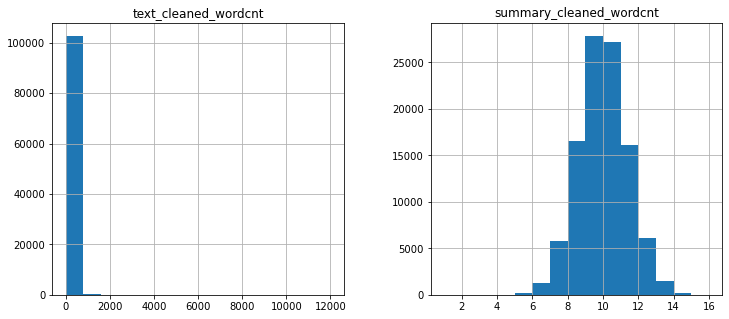

>>> summary with 0-15 words : 99.97%
>>> text with 0-100 words   : 95.78%


In [12]:
# Check the distribution of word count
pre_df[['text_cleaned_wordcnt', 'summary_cleaned_wordcnt']].hist(figsize=(12, 5), bins=15)
plt.show()

# Check the percentage of summary with 0-15 words
print(f'>>> summary with 0-15 words : {sum(pre_df.summary_cleaned_wordcnt < 15)/len(pre_df)*100:.2f}%')

# Check the percentage of text with 0-100 words
print(f'>>> text with 0-100 words   : {sum(pre_df.text_cleaned_wordcnt < 100)/len(pre_df)*100:.2f}%')